In [1]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from src.network import DQN
from src.utils import get_screen, ReplayMemory, select_action, optimize_model, plot_durations

%load_ext autoreload
%autoreload 2

In [2]:
env = gym.make('CartPole-v0').unwrapped

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


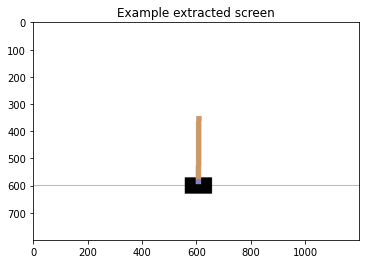

In [3]:
env.reset()
plt.figure()
img = plt.imshow(env.render(mode='rgb_array'))
plt.title('Example extracted screen')
plt.show()

In [4]:
BATCH_SIZE = 512
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 10

init_screen = get_screen(env, device)
_, _, screen_height, screen_width = init_screen.shape

n_actions = env.action_space.n

policy_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.AdamW(policy_net.parameters())
memory = ReplayMemory(10000)
steps_done = 0
episode_durations = []

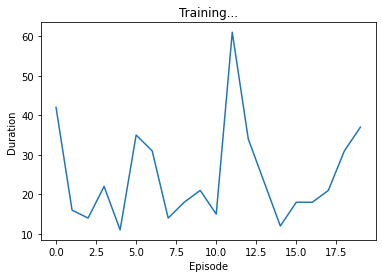

In [ ]:
num_episodes = 500
for i_episode in range(num_episodes):
    env.reset()
    last_screen = get_screen(env, device)
    current_screen = get_screen(env, device)
    state = current_screen - last_screen
    for t in count():
        action = select_action(state, n_actions, policy_net, device,
                               EPS_START, EPS_END, EPS_DECAY, steps_done)
        _, reward, done, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)

        last_screen = current_screen
        current_screen = get_screen(env, device)
        if not done:
            next_state = current_screen - last_screen
        else:
            next_state = None

        memory.push(state, action, next_state, reward)
        state = next_state
        optimize_model(memory, BATCH_SIZE, device,
                       policy_net, target_net, GAMMA, optimizer)
        if done:
            episode_durations.append(t + 1)
            plot_durations(episode_durations)
            break
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

print('Complete')
env.render()
env.close()
plt.ioff()
plt.show()